## Generating vessels from a dataset

In this example we will discuss how to generate vessels from existing dataset in OpenTNSim and how to analyse specific locking output.

We take the following steps:

1. [Imports](#1-imports)
2. [Create vessel](#2-create-vessel)
3. [Create graph](#3-create-graph)
4. [Run simulation](#4-run-simulation)
5. [Inspect output](#5-inspect-output)

### 1. Imports
We start with importing the required libraries

In [1]:
# package(s) related to time, space and id
import datetime, time
import platform
import random
import os
import pathlib

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# OpenTNSIM
import opentnsim 
import opentnsim.core as core
import opentnsim.graph_module as graph_module
import opentnsim.plot as plot
import opentnsim.model as model

# Used for mathematical functions
import math             

# Used for making the graph to visualize our problem
import networkx as nx  

# Graph location
location_graph = (os.path.relpath(pathlib.Path.cwd(), "notebooks"))
name_graph = "notebooks/Shape-Files/Rotterdam-Antwerpen-corridor/edges_2.shp"

# Vessel database
location_vessel_database = "notebooks/Vessels/richtlijnen-vaarwegen-2017.csv"

print('This notebook has been tested with OpenTNSim version {}'.format(opentnsim.__version__))

This notebook has been tested with OpenTNSim version 1.0.0


### 2. Create vessel
The following section shows how to use the file `richtlijnen-vaarwegen-2017.csv` as a database for generating vessels. Inspect the file be opening it in excel to get a feel for how these datasets are structured and how you can use pandas to process this data.

In [7]:
#Load in the data
vessel_db = pd.read_csv(os.path.join(location_graph, location_vessel_database))
vessel_db.head()



,vessel_id,vessel_type,width,length,height_empty,height_full,draught_empty,draught_full,capacity,installed_power
0,12ad8a02-4aef-11e9-9940-b469212bff5b,CEMT - I,5.05,38.5,4.65,3.35,1.2,2.5,365,175
1,17746aee-4aef-11e9-8ebf-b469212bff5b,CEMT - II,6.60,55.0,5.80,4.60,1.4,2.6,615,250
2,1be5fb2e-4aef-11e9-9bfb-b469212bff5b,CEMT - III,8.20,85.0,6.30,5.10,1.5,2.7,1250,435
3,208a5aca-4aef-11e9-b7e9-b469212bff5b,CEMT - IV,9.50,105.0,6.70,5.30,1.6,3.0,2040,690
4,24f93100-4aef-11e9-8ff9-b469212bff5b,CEMT - Va,11.40,135.0,7.10,5.40,1.8,3.5,3735,1425


We start with creating a vessel class. We call this class a *Vessel*, and add a number of OpenTNSim mix-ins to this class. Each mix-in requires certain input parameters. 

The following mix-ins are sufficient to create a vessel for our problem: 
* _Identifiable_ - allows to give the vessel a name and a random ID, 
* _Movable_ - allows the vessel to move, with a fixed speed, while logging this activity,
   * Movable in turn relies on the mix-ins: _Locatable_, _Routeable_, and _Log_
* _VesselProperties_ - allows to give the vessel specific properties, 
* _HasContainer_ - allows vessel to have cargo on board, 
* _HasResource_ - allows vessel to be requested 

These mixi-ins and the `vessels_db` dataframe are then combined in the vessel generator:

In [8]:
# Vessel type
Vessel = type('Vessel', 
              (core.Identifiable, core.Movable, core.HasContainer,
               core.VesselProperties, core.HasResource, core.Routeable), 
              {})

generator = model.VesselGenerator(Vessel, vessel_db)

### 3. Create graph

The cel below visualizes the problem. In graph theory the red dots are called *edges* and the lines are called *vertices*. Vessels (or any other object) move from edge 1 to edge 3 and from edge 4 to edge 2. The added complexity is that vertice 5-6 only allows traffic in one direction at a time. Vessels can travel simultanously in one direction.

**Important**: 

If you use windows and get the following error "ImportError: read_shp requires OGR: http://www.gdal.org/", you probably have [this issue](https://github.com/conda-forge/gdal-feedstock/issues/219). Solving it is possible by running the following commands in your terminal (as explained [here](https://gis.stackexchange.com/questions/294231/installing-gdal-with-anaconda)):

```bash
#Create a new virtual environment
conda create -n testgdal -c conda-forge gdal vs2015_runtime=14

#Activate virtual environment
activate testgdal

#Open Jupyter notebook
jupyer notebook
```

In [2]:
graph = graph_module.Graph()
graph.from_shape(location_graph, name_graph)

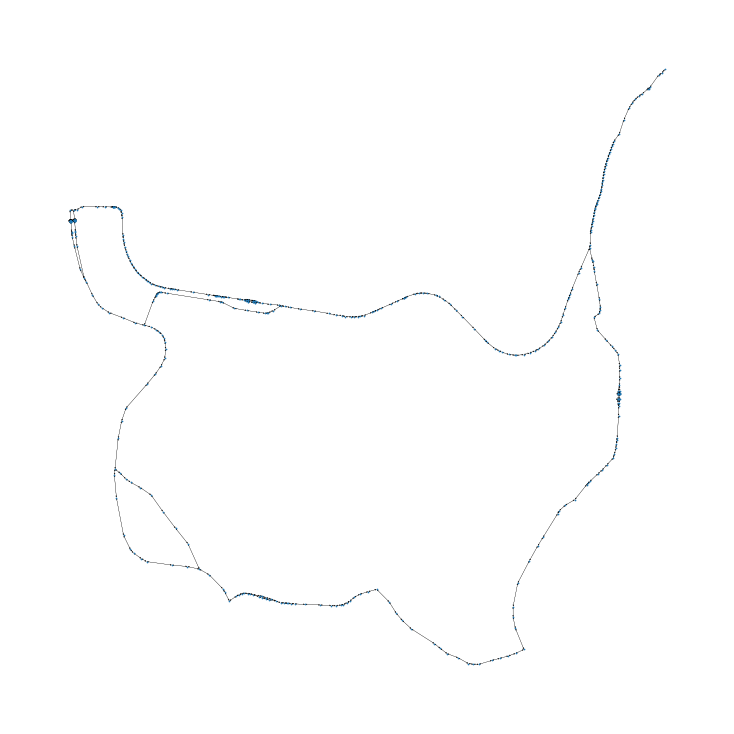

In [3]:
graph.create_graph_new_projection()
graph.plot()

### 4. Run simulation

In [9]:
# Start simpy environment
simulation_start = datetime.datetime.now()
env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))

# Add graph to environment
graph.add_resources(list(graph.graph.edges), np.ones(len(list(graph.graph.edges))), env)
env.FG = graph.graph

In [10]:
def start(env, vessel):
    while True:
        
        vessel.log_entry("Start sailing", env.now, "0", vessel.geometry)
        yield from vessel.move()
        vessel.log_entry("Stop sailing", env.now, "0", vessel.geometry)

        if vessel.geometry == nx.get_node_attributes(env.FG, "geometry")[vessel.route[-1]]:
            break

In [11]:
vessels = []

# Add 10 vessels to the simulation
for i in range(10):
    random_1 = random.choice(list(graph.graph))
    random_2 = random.choice(list(graph.graph))
    path = nx.dijkstra_path(graph.graph, random_1, random_2)
    
    vessel = generator.generate(env, "Vessel " + str(i))
    vessel.route = path
    vessel.geometry = nx.get_node_attributes(env.FG, "geometry")[vessel.route[0]]
    vessels.append(vessel)
    
    # Add the movements of the vessel to the simulation
    env.process(start(env, vessel))

In [12]:
# Run simulation
env.run()

### 5. Inspect output

In [13]:
df = pd.DataFrame.from_dict(vessel.log)
df.head()

,Message,Timestamp,Value,Geometry
0,Start sailing,2022-05-11 10:36:34.000000,0,POINT (51.5136 4.2198)
1,"Waiting to pass edge (51.513600, 4.219800) - (...",2022-05-11 10:36:34.000000,0,POINT (51.5136 4.2198)
2,"Waiting to pass edge (51.513600, 4.219800) - (...",2022-05-11 10:46:29.322742,0,POINT (51.5136 4.2198)
3,"Sailing from node (51.513600, 4.219800) to nod...",2022-05-11 10:46:29.322742,0,POINT (51.5136 4.2198)
4,"Sailing from node (51.513600, 4.219800) to nod...",2022-05-11 10:56:24.645483,0,POINT (51.5184 4.2222)


In [14]:
vessel.log

{'Message': ['Start sailing',
  'Waiting to pass edge (51.513600, 4.219800) - (51.518400, 4.222200) start',
  'Waiting to pass edge (51.513600, 4.219800) - (51.518400, 4.222200) stop',
  'Sailing from node (51.513600, 4.219800) to node (51.518400, 4.222200) start',
  'Sailing from node (51.513600, 4.219800) to node (51.518400, 4.222200) stop',
  'Sailing from node (51.518400, 4.222200) to node (51.519631, 4.222915) start',
  'Sailing from node (51.518400, 4.222200) to node (51.519631, 4.222915) stop',
  'Sailing from node (51.519631, 4.222915) to node (51.521194, 4.223780) start',
  'Sailing from node (51.519631, 4.222915) to node (51.521194, 4.223780) stop',
  'Sailing from node (51.521194, 4.223780) to node (51.523700, 4.225200) start',
  'Sailing from node (51.521194, 4.223780) to node (51.523700, 4.225200) stop',
  'Waiting to pass edge (51.523700, 4.225200) - (51.529474, 4.228499) start',
  'Waiting to pass edge (51.523700, 4.225200) - (51.529474, 4.228499) stop',
  'Sailing from 